In [73]:
import pybaseball as pyb
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

In [3]:
a = time()
df_2023 = pyb.statcast(start_dt='2023-03-30', end_dt='2023-09-29')
df_2024 = pyb.statcast(start_dt='2024-03-30', end_dt='2024-09-29')
df_2025 = pyb.statcast(start_dt='2025-03-30', end_dt='2025-09-29')
print(time() - a)

This is a large query, it may take a moment to complete


c:\Users\Mbubs\miniconda3\envs\sports\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/184 [00:00<?, ?it/s]c:\Users\Mbubs\miniconda3\envs\sports\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly inste

This is a large query, it may take a moment to complete


c:\Users\Mbubs\miniconda3\envs\sports\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/184 [00:00<?, ?it/s]c:\Users\Mbubs\miniconda3\envs\sports\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly inste

This is a large query, it may take a moment to complete


c:\Users\Mbubs\miniconda3\envs\sports\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/184 [00:00<?, ?it/s]c:\Users\Mbubs\miniconda3\envs\sports\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly inste

302.3536081314087


In [4]:
df_2023 = df_2023.iloc[::-1]
df_2024 = df_2024.iloc[::-1]
df_2025 = df_2025.iloc[::-1]

In [5]:
df = df_2025

In [6]:
first_pitch_per_pitcher = df.groupby(['game_pk', 'pitcher']).head(1)

# Step 2: Starters are those whose first pitch came in inning 1 (top or bottom)
# Warning, this line really takes anyone whose first pitch was in 1st inning and calls them a starter
# So if a starter has a meltdown and a reliever comes in in the 1st, this is still labeling the reliever a starter
starters = first_pitch_per_pitcher[first_pitch_per_pitcher['inning'] == 1]

# Step 3: Create starter ID pairs (game_pk, pitcher)
starter_ids = starters[['game_pk', 'pitcher']].drop_duplicates()

# Step 4: Label each row in the full DataFrame as 'starter' or 'reliever'
df = df.copy()  # avoid SettingWithCopyWarning

is_starter = pd.MultiIndex.from_frame(df[['game_pk','pitcher']]).isin(
    pd.MultiIndex.from_frame(starter_ids)
)
df['role'] = np.where(is_starter, 'starter', 'reliever')


In [130]:
starters = df[df['role'] == 'starter'].copy()

In [131]:
starters['base_state'] = (
    starters['on_1b'].notna().astype(int).astype(str) +
    starters['on_2b'].notna().astype(int).astype(str) +
    starters['on_3b'].notna().astype(int).astype(str)
)

In [132]:
starters['pitch_count'] = starters.groupby(['game_pk', 'pitcher']).cumcount() + 1

In [ ]:
### need to figure out how to compute BoLI to remove the de-leveraged effect 

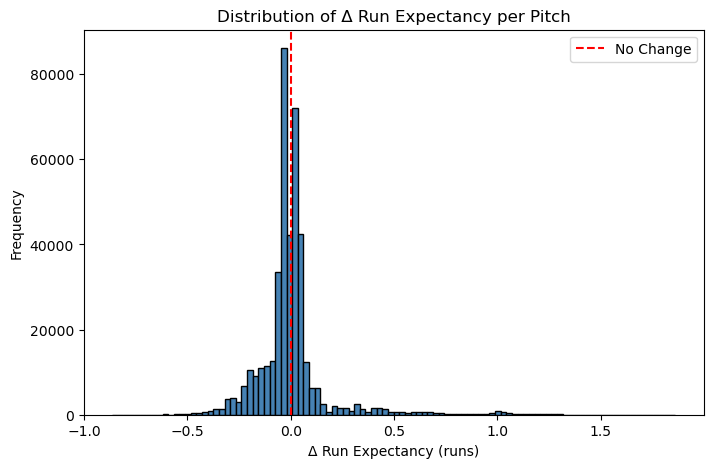

In [129]:
plt.figure(figsize=(8,5))
plt.hist(starters['lrv'], bins=100, color='steelblue', edgecolor='k')
plt.axvline(0, color='red', linestyle='--', label='No Change')
plt.title('Distribution of Δ Run Expectancy per Pitch')
plt.xlabel('Δ Run Expectancy (runs)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
starters['lrv_norm'] = (
    starters.groupby('pitcher')['lrv']
      .transform(lambda x: (x - x.mean()) / x.std())
)

#target variable next pitches' lrv 
starters['lrv_next'] = (
    starters.groupby('pitcher')['lrv_norm'].shift(-1)
)

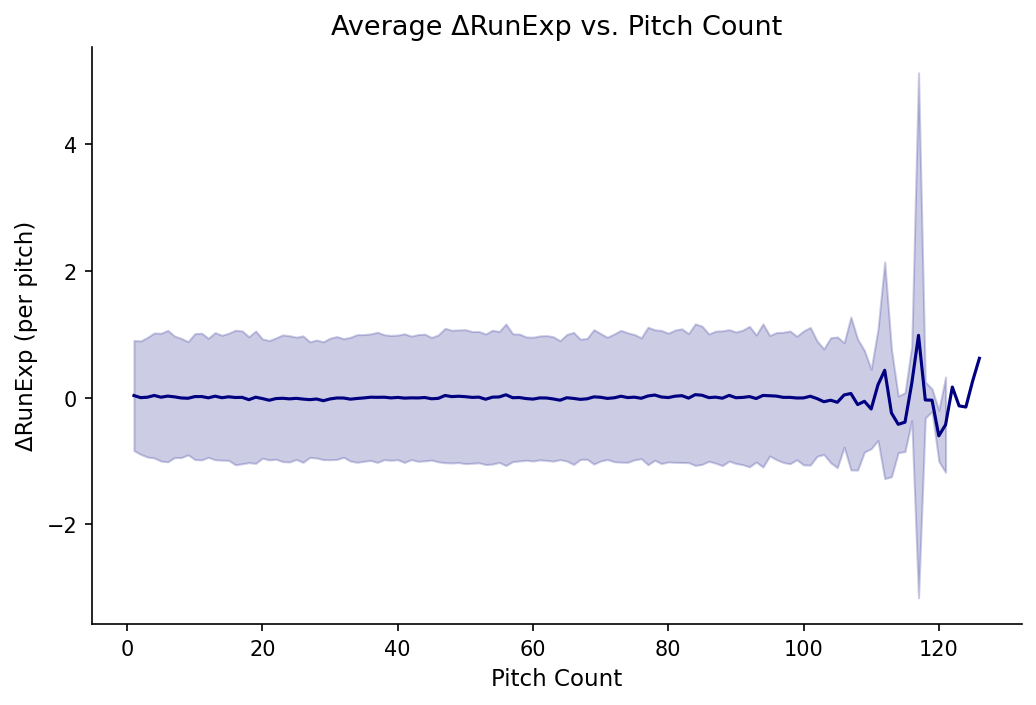

In [124]:
plt.figure(figsize=(8,5), dpi=150)
sns.lineplot(
    data=starters, x='pitch_count', y='lrv_norm',
    errorbar='sd', estimator='mean', color='navy'
)
plt.title("Average ΔRunExp vs. Pitch Count", fontsize=13)
plt.xlabel("Pitch Count", fontsize=11)
plt.ylabel("ΔRunExp (per pitch)", fontsize=11)
sns.despine()

In [126]:
starters['pitch_bin'] = pd.cut(
    starters['pitch_count'], 
    bins=np.arange(0, 130, 10), 
    right=False
)

agg_pitch_count = (
    starters.groupby('pitch_bin')['lrv_norm']
    .agg(
        count='count',
        mean='mean',
        var='var',
        tail_freq=lambda x: (x > 0.5).mean(),
        skew=lambda x: skew(x, nan_policy='omit'),
        kurtosis=lambda x: kurtosis(x, fisher=True, nan_policy='omit')
    )
    .reset_index()
)

C:\Users\Mbubs\AppData\Local\Temp\ipykernel_12984\2063412862.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  starters.groupby('pitch_bin')['lrv_norm']


In [127]:
agg_pitch_count

,pitch_bin,count,mean,var,tail_freq,skew,kurtosis
0,"[0, 10)",43232,0.011323,0.901259,0.102771,2.706991,13.824481
1,"[10, 20)",47821,0.004637,1.015101,0.09935,3.071716,17.168472
2,"[20, 30)",47344,-0.023612,0.916654,0.094479,2.848828,16.26078
3,"[30, 40)",46839,-0.006019,0.969356,0.09902,2.870952,15.887557
4,"[40, 50)",46247,0.003193,1.01967,0.101088,2.92713,15.797735
5,"[50, 60)",45477,0.004975,1.072444,0.101216,3.084251,16.840531
6,"[60, 70)",43920,-0.014307,0.973614,0.097404,2.925149,16.420198
7,"[70, 80)",39792,0.008425,1.029083,0.104066,2.930284,15.799842
8,"[80, 90)",30611,0.016702,1.099798,0.106857,3.043508,16.420447
9,"[90, 100)",14231,0.00934,1.086684,0.107512,2.982132,16.578786


C:\Users\Mbubs\AppData\Local\Temp\ipykernel_12984\3564403618.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(agg_pitch_count['pitch_bin'].astype(str), rotation=45)


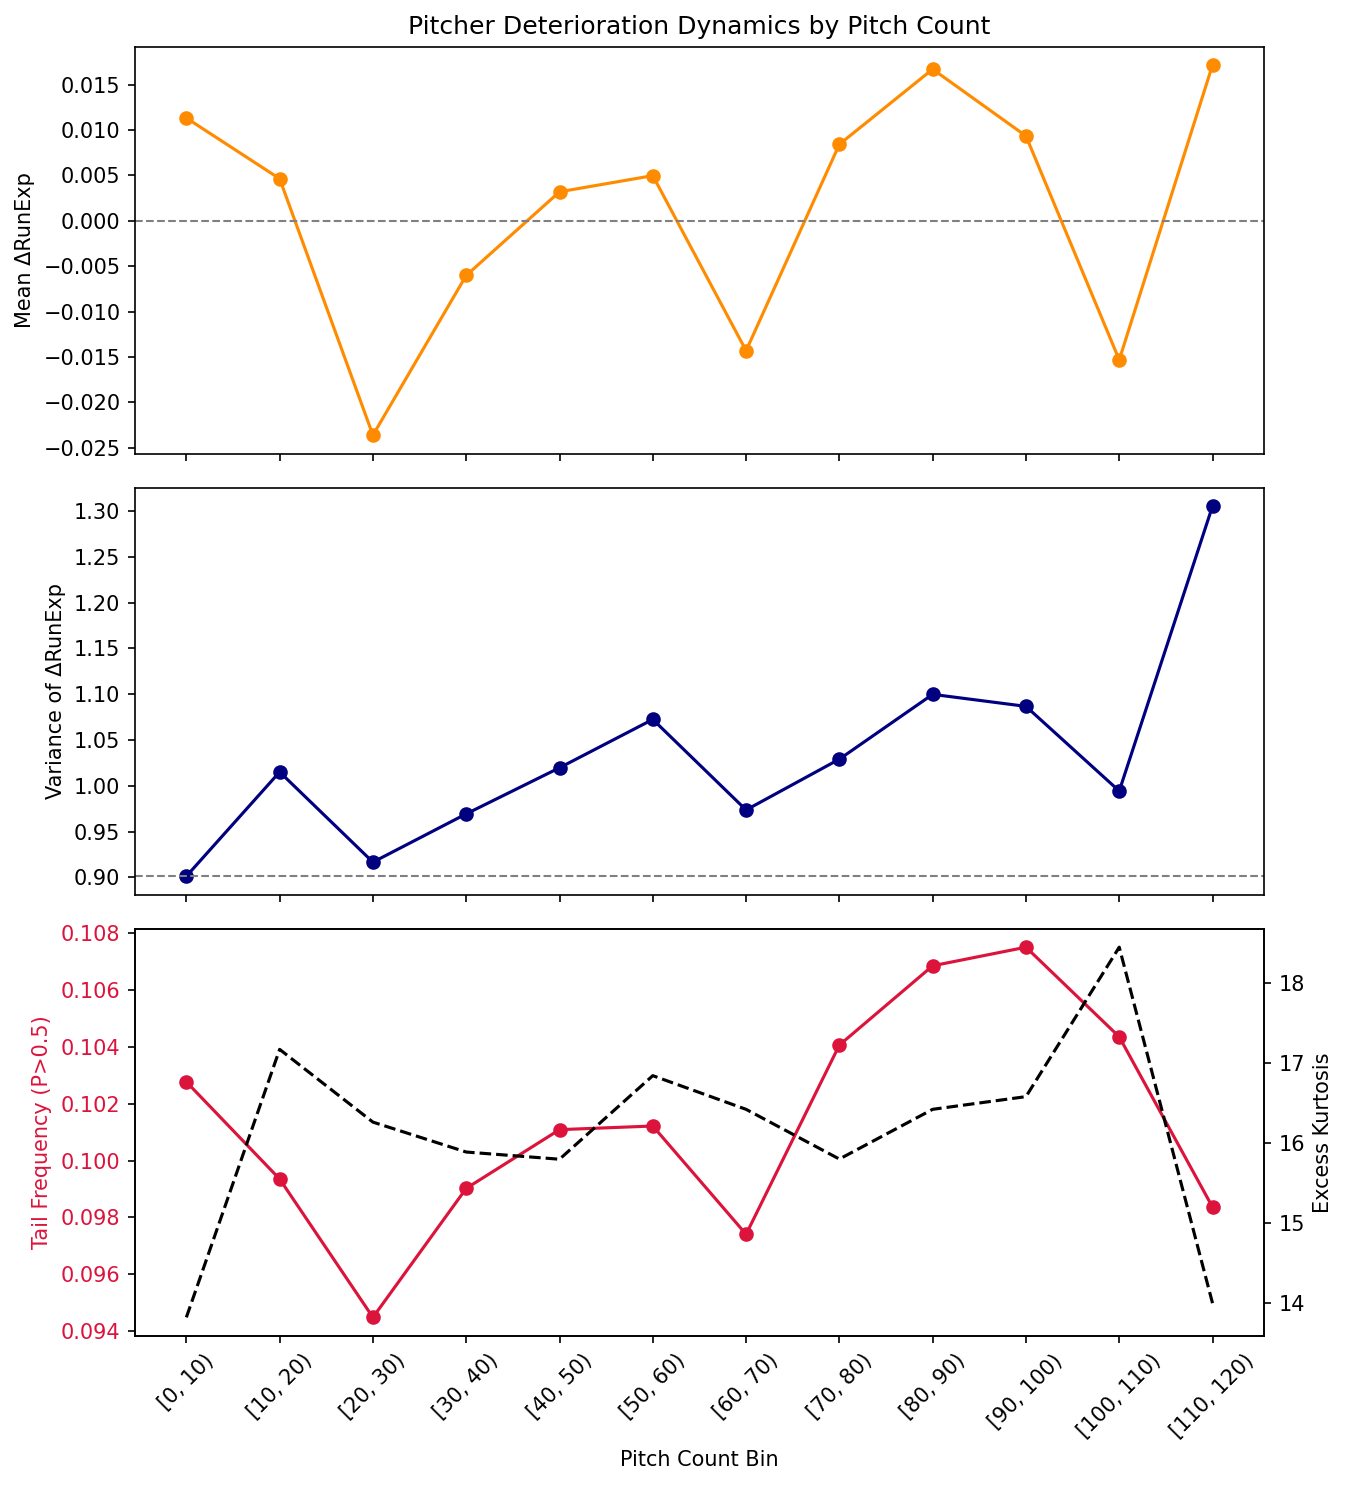

In [128]:

fig, axes = plt.subplots(3, 1, figsize=(9, 10), dpi=150, sharex=True)

# ---- (1) Mean ----
axes[0].plot(agg_pitch_count['pitch_bin'].astype(str), agg_pitch_count['mean'], color='darkorange', marker='o')
axes[0].set_ylabel('Mean ΔRunExp')
axes[0].set_title('Pitcher Deterioration Dynamics by Pitch Count')
axes[0].axhline(0, color='gray', lw=1, ls='--')

# ---- (2) Variance ----
axes[1].plot(agg_pitch_count['pitch_bin'].astype(str), agg_pitch_count['var'], color='navy', marker='o')
axes[1].set_ylabel('Variance of ΔRunExp')
axes[1].axhline(agg_pitch_count['var'].iloc[0], color='gray', lw=1, ls='--')

# ---- (3) Tail frequency vs. Kurtosis ----
ax3 = axes[2]
ax3.plot(agg_pitch_count['pitch_bin'].astype(str), agg_pitch_count['tail_freq'], color='crimson', marker='o', label='P(ΔRE > 1)')
ax3.set_ylabel('Tail Frequency (P>0.5)', color='crimson')
ax3.tick_params(axis='y', labelcolor='crimson')

ax4 = ax3.twinx()
ax4.plot(agg_pitch_count['pitch_bin'].astype(str), agg_pitch_count['kurtosis'], color='black', lw=1.5, ls='--', label='Kurtosis')
ax4.set_ylabel('Excess Kurtosis', color='black')
ax4.tick_params(axis='y', labelcolor='black')

axes[2].set_xlabel('Pitch Count Bin')
axes[2].set_xticklabels(agg_pitch_count['pitch_bin'].astype(str), rotation=45)
plt.tight_layout()
plt.show()

In [83]:
agg_inning = (
    starters.groupby('inning')['dre_norm']
    .agg(
        count='count',
        mean='mean',
        std='std',
        skew=lambda x: skew(x, nan_policy='omit'),
        kurtosis=lambda x: kurtosis(x, fisher=True, nan_policy='omit')
    )
    .reset_index()
)

In [84]:
agg_inning

,inning,count,mean,std,skew,kurtosis
0,1,80969,0.009165,1.014178,4.064605,30.774076
1,2,76892,-0.015853,0.969825,4.108723,33.360161
2,3,74748,-0.001965,0.987555,3.92211,29.63229
3,4,69408,0.001853,1.014141,4.036369,30.774049
4,5,58834,0.001236,0.994627,3.907408,29.967752
5,6,34962,0.015713,1.033343,4.035928,30.376179
6,7,10271,-0.007318,1.010388,4.079311,32.290626
7,8,1619,-0.044164,0.865781,2.773365,16.448469
8,9,376,0.052574,1.21209,5.424955,47.233375


In [47]:
starters.loc[starters['delta_run_exp'] >= 2, ['on_1b', 'on_2b', 'on_3b', 'events', 'type', 'outs_when_up','balls','strikes','delta_run_exp','bat_score','post_bat_score']]

,on_1b,on_2b,on_3b,events,type,outs_when_up,balls,strikes,delta_run_exp,bat_score,post_bat_score
597,<NA>,<NA>,<NA>,home_run,X,2,0,2,2.696,1,2
1124,<NA>,<NA>,<NA>,home_run,X,2,1,1,2.612,2,3
525,592450,<NA>,<NA>,home_run,X,2,1,2,2.312,3,5
327,642136,<NA>,<NA>,home_run,X,2,2,1,2.186,7,9
1237,<NA>,<NA>,<NA>,home_run,X,2,0,0,2.596,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1653,624424,<NA>,<NA>,home_run,X,2,1,1,2.239,0,2
2439,695657,<NA>,<NA>,home_run,X,2,2,2,2.279,0,2
555,<NA>,<NA>,<NA>,home_run,X,2,1,2,2.674,2,3
345,672820,<NA>,<NA>,home_run,X,2,2,2,2.279,3,5


In [24]:
pitcher = 608379
game_num = 778510

In [27]:
wacha = starters.loc[(starters['game_pk'] == game_num) & (starters['pitcher'] == pitcher), :]

In [39]:
wacha['delta_run_exp']

3479    0.042
3374    0.077
3264   -0.073
3154   -0.073
3086    0.465
        ...  
88      0.031
81     -0.046
76     -0.057
63        0.0
58     -0.242
Name: delta_run_exp, Length: 87, dtype: Float64

In [35]:
wacha[['events', 'type']][:5]

,events,type
3479,NaN,B
3374,NaN,B
3264,NaN,S
3154,NaN,S
3086,single,X


In [31]:
wacha[['post_home_score','post_away_score','home_team']]

,post_home_score,post_away_score,home_team
3479,0,0,KC
3374,0,0,KC
3264,0,0,KC
3154,0,0,KC
3086,0,0,KC
...,...,...,...
88,0,1,KC
81,0,1,KC
76,0,1,KC
63,0,1,KC


In [ ]:
# evaulate the correctness of the code with the game and pitcher example
# look into a basemodel to fit the data and visualize the rolling average window in the game 
# how does velo vs window look like etc 
# in instance in which we did well in can we visualize the resulting reason why and vice versa
# specific pitchers doing well
# visuals like batters box 
# feature engineering
# latter make normalized verison w/o data leakage ie for first game issues just use
# unnormalized delta run to see its raw form 